# Assignment 2

In this assignment you have to create a classifier using the **Inception V4 model** and the **Natural Images** dataset (given with the assignment). You can read more about **Inception V4 model** from the source: https://arxiv.org/pdf/1602.07261.pdf.

Dataset: https://drive.google.com/file/d/1B3mSMit48EkPJ4ZAnjSWpWOLoVjkEltG/view?usp=sharing

### Grading

1.   Implementation of **Inception V4 model**. (30pt)
2.   Data Augmentation. (20pt)
2.   Training the model. (20pt)
3.   Test accuracy higher than 80%. (20 pt)
4.   Test accuracy higher than 90%. (10 pt)

### Submission policy

You have to submit 3 files in a single folder named with your student id, for example 180102030. The folder should be compressed in ZIP format.

**180102030/**

1. **source.ipynb** - Please write your name and surname on the top in addition
2. **source.html** (you can miss this file, but I suggest you to upload it as well. If source code would have problems, then this file guarantees your work done) - This is HTML version of your source code. You can export the HTML version of your work in Jupyter Notebook.
3. **model.pt** - Do not forget to save the state of you WEIGHTS!!!! You can read more about it from: https://pytorch.org/tutorials/beginner/saving_loading_models.html

## Inception v4

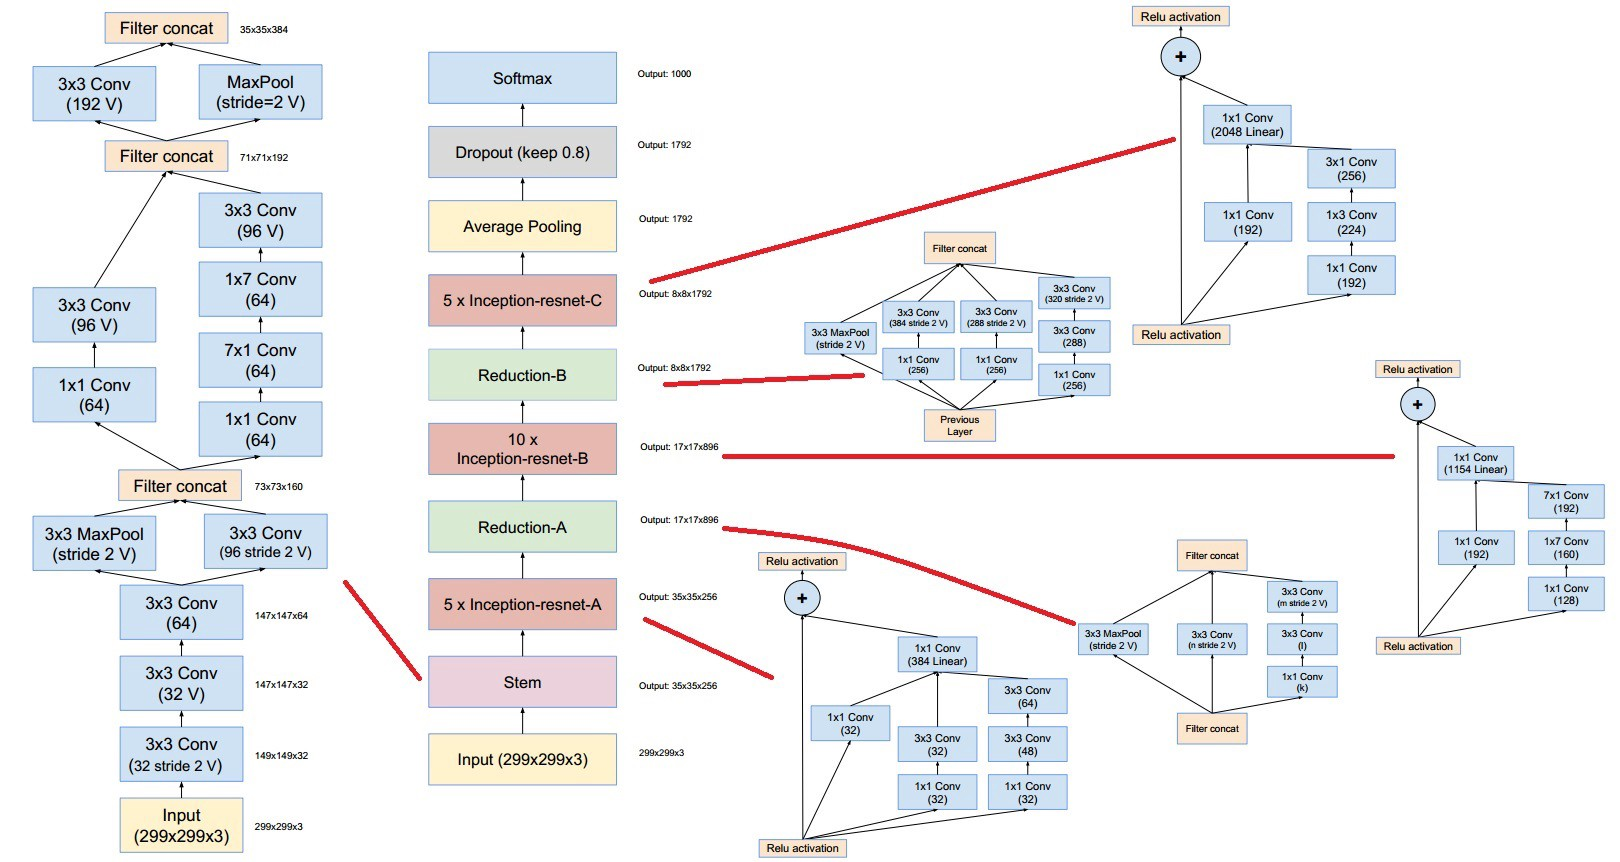

In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image

import torch.nn as nn
import torch.nn.functional as F

In [2]:
# TODO: Implementation of the Inception V4 model

class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, stride=1, bias=True):
        super(Conv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Stem(nn.Module):
    def __init__(self, in_channels):
        super(Stem, self).__init__()
        self.conv2d_1a_3x3 = Conv2d(in_channels, 32, 3, stride=2, padding=0, bias=False)
        self.conv2d_2a_3x3 = Conv2d(32, 32, 3, stride=1, padding=0, bias=False)
        self.conv2d_2b_3x3 = Conv2d(32, 64, 3, stride=1, padding=1, bias=False)
        self.mixed_3a_branch_0 = nn.MaxPool2d(3, stride=2, padding=0)
        self.mixed_3a_branch_1 = Conv2d(64, 96, 3, stride=2, padding=0, bias=False)
        self.mixed_4a_branch_0 = nn.Sequential(
            Conv2d(160, 64, 1, stride=1, padding=0, bias=False),
            Conv2d(64, 96, 3, stride=1, padding=0, bias=False),
        )
        self.mixed_4a_branch_1 = nn.Sequential(
            Conv2d(160, 64, 1, stride=1, padding=0, bias=False),
            Conv2d(64, 64, (1, 7), stride=1, padding=(0, 3), bias=False),
            Conv2d(64, 64, (7, 1), stride=1, padding=(3, 0), bias=False),
            Conv2d(64, 96, 3, stride=1, padding=0, bias=False)
        )
        self.mixed_5a_branch_0 = Conv2d(192, 192, 3, stride=2, padding=0, bias=False)
        self.mixed_5a_branch_1 = nn.MaxPool2d(3, stride=2, padding=0)
    def forward(self, x):
        x = self.conv2d_1a_3x3(x)
        x = self.conv2d_2a_3x3(x)
        x = self.conv2d_2b_3x3(x)
        x0 = self.mixed_3a_branch_0(x)
        x1 = self.mixed_3a_branch_1(x)
        x = torch.cat((x0, x1), dim=1)
        x0 = self.mixed_4a_branch_0(x)
        x1 = self.mixed_4a_branch_1(x)
        x = torch.cat((x0, x1), dim=1)
        x0 = self.mixed_5a_branch_0(x)
        x1 = self.mixed_5a_branch_1(x)
        x = torch.cat((x0, x1), dim=1)
        return x


class ReductionA(nn.Module):
    def __init__(self, in_channels, k, l, m, n):
        super(ReductionA, self).__init__()
        self.branch_0 = Conv2d(in_channels, n, 3, stride=2, padding=0, bias=False)
        self.branch_1 = nn.Sequential(
            Conv2d(in_channels, k, 1, stride=1, padding=0, bias=False),
            Conv2d(k, l, 3, stride=1, padding=1, bias=False),
            Conv2d(l, m, 3, stride=2, padding=0, bias=False),
        )
        self.branch_2 = nn.MaxPool2d(3, stride=2, padding=0)
    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x2 = self.branch_2(x)
        return torch.cat((x0, x1, x2), dim=1)


class InceptionResNetA(nn.Module):
    def __init__(self, in_channels, scale=1.0):
        super(InceptionResNetA, self).__init__()
        self.scale = scale
        self.branch_0 = Conv2d(in_channels, 32, 1, stride=1, padding=0, bias=False)
        self.branch_1 = nn.Sequential(
            Conv2d(in_channels, 32, 1, stride=1, padding=0, bias=False),
            Conv2d(32, 32, 3, stride=1, padding=1, bias=False)
        )
        self.branch_2 = nn.Sequential(
            Conv2d(in_channels, 32, 1, stride=1, padding=0, bias=False),
            Conv2d(32, 48, 3, stride=1, padding=1, bias=False),
            Conv2d(48, 64, 3, stride=1, padding=1, bias=False)
        )
        self.conv = nn.Conv2d(128, 384, 1, stride=1, padding=0, bias=True)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x2 = self.branch_2(x)
        x_res = torch.cat((x0, x1, x2), dim=1)
        x_res = self.conv(x_res)
        return self.relu(x + self.scale * x_res)


class InceptionResNetB(nn.Module):
    def __init__(self, in_channels, scale=1.0):
        super(InceptionResNetB, self).__init__()
        self.scale = scale
        self.branch_0 = Conv2d(in_channels, 192, 1, stride=1, padding=0, bias=False)
        self.branch_1 = nn.Sequential(
            Conv2d(in_channels, 128, 1, stride=1, padding=0, bias=False),
            Conv2d(128, 160, (1, 7), stride=1, padding=(0, 3), bias=False),
            Conv2d(160, 192, (7, 1), stride=1, padding=(3, 0), bias=False)
        )
        self.conv = nn.Conv2d(384, 1152, 1, stride=1, padding=0, bias=True)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x_res = torch.cat((x0, x1), dim=1)
        x_res = self.conv(x_res)
        return self.relu(x + self.scale * x_res)


class ReducitonB(nn.Module):
    def __init__(self, in_channels):
        super(ReducitonB, self).__init__()
        self.branch_0 = nn.Sequential(
            Conv2d(in_channels, 256, 1, stride=1, padding=0, bias=False),
            Conv2d(256, 384, 3, stride=2, padding=0, bias=False)
        )
        self.branch_1 = nn.Sequential(
            Conv2d(in_channels, 256, 1, stride=1, padding=0, bias=False),
            Conv2d(256, 288, 3, stride=2, padding=0, bias=False),
        )
        self.branch_2 = nn.Sequential(
            Conv2d(in_channels, 256, 1, stride=1, padding=0, bias=False),
            Conv2d(256, 288, 3, stride=1, padding=1, bias=False),
            Conv2d(288, 320, 3, stride=2, padding=0, bias=False)
        )
        self.branch_3 = nn.MaxPool2d(3, stride=2, padding=0)
    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x2 = self.branch_2(x)
        x3 = self.branch_3(x)
        return torch.cat((x0, x1, x2, x3), dim=1)


class InceptionResNetC(nn.Module):
    def __init__(self, in_channels, scale=1.0, activation=True):
        super(InceptionResNetC, self).__init__()
        self.scale = scale
        self.activation = activation
        self.branch_0 = Conv2d(in_channels, 192, 1, stride=1, padding=0, bias=False)
        self.branch_1 = nn.Sequential(
            Conv2d(in_channels, 192, 1, stride=1, padding=0, bias=False),
            Conv2d(192, 224, (1, 3), stride=1, padding=(0, 1), bias=False),
            Conv2d(224, 256, (3, 1), stride=1, padding=(1, 0), bias=False)
        )
        self.conv = nn.Conv2d(448, 2144, 1, stride=1, padding=0, bias=True)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x_res = torch.cat((x0, x1), dim=1)
        x_res = self.conv(x_res)
        if self.activation:
            return self.relu(x + self.scale * x_res)
        return x + self.scale * x_res


class InceptionV4(torch.nn.Module):
    def __init__(self, num_classes, in_channels=3, k=256, l=256, m=384, n=384, p=0.8):
        super(InceptionV4, self).__init__()
        self.features = nn.Sequential(
            Stem(in_channels),
            *[InceptionResNetA(384, 0.17) for _ in range(5)],
            ReductionA(384, k, l, m, n),
            *[InceptionResNetB(1152, 0.10) for _ in range(10)],
            ReducitonB(1152),
            *[InceptionResNetC(2144, 0.20) for _ in range(4)],
            InceptionResNetC(2144, activation=False),
        )
        self.conv = Conv2d(2144, 1536, 1, stride=1, padding=0, bias=False)
        self.global_average_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p)
        self.linear = nn.Linear(1536, num_classes)
    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.global_average_pooling(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((299, 299)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomPerspective(distortion_scale=0.2),
    torchvision.transforms.RandomRotation(15),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=0, std=1),
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((299, 299)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=0, std=1),
])

train_dataset = torchvision.datasets.ImageFolder(root='drive/MyDrive/dataA3/train', transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(root='drive/MyDrive/dataA3/val', transform=val_transforms)

In [5]:
def accuracy(outputs, labels):
    _, preds = torch.max(F.log_softmax(outputs, dim=1), dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def predicts(outputs):
    _, preds = torch.max(F.log_softmax(outputs, dim=1), dim=1)
    return preds

criterion = torch.nn.CrossEntropyLoss()

In [6]:
# TODO: Implementations of the train and the evaluate functions

def train(model, batch, optimizer):
    model.train()
    optimizer.zero_grad()
    inputs, labels = batch
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = model(inputs)
    l = criterion(outputs, labels)
    l.backward()
    optimizer.step()
    return l


def evaluate(model, batch, optimizer):
    model.eval()
    inputs, labels = batch
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = model(inputs)
    a = accuracy(outputs, labels)
    l = criterion(outputs, labels)
    return a, l

In [7]:
model = InceptionV4(8)
model.cuda()
model.load_state_dict(torch.load('drive/MyDrive/dataA3/model.pt'))

<All keys matched successfully>

In [8]:
# TODO: Implementations of the train process

LEARNING_RATE = 0.000001
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
epoches = 1

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

for epoch in range(epoches):
    print('Epoch:', epoch + 1)
    c = 0
    for batch in train_loader:
        l = train(model, batch, optimizer)
        c += len(batch[0])
        if c % 320 == 0: print("[%d/%d] Loss: %.2f" % (c, len(train_dataset), l.item()))
    for batch in train_loader:
        a, l = evaluate(model, batch, optimizer)
        print("Train Loss: %.2f, Train Accuracy: %.2f" % (l.item(), a.item()))
        break
    acc = 0; loo = 0; d = 0
    for batch in val_loader:
        a, l = evaluate(model, batch, optimizer)
        acc += a.item()
        loo += l.item()
        d += 1
    print("Val Loss: %.2f, Val Accuracy: %.2f" % (loo/d, acc/d))
    torch.save(model.state_dict(), 'drive/MyDrive/dataA3/model.pt')

Epoch: 1
[320/5533] Loss: 0.11
[640/5533] Loss: 0.09
[960/5533] Loss: 0.12
[1280/5533] Loss: 0.12
[1600/5533] Loss: 0.07
[1920/5533] Loss: 0.10
[2240/5533] Loss: 0.23
[2560/5533] Loss: 0.29
[2880/5533] Loss: 0.20
[3200/5533] Loss: 0.40
[3520/5533] Loss: 0.19
[3840/5533] Loss: 0.24
[4160/5533] Loss: 0.17
[4480/5533] Loss: 0.24
[4800/5533] Loss: 0.38
[5120/5533] Loss: 0.38
[5440/5533] Loss: 0.14
Train Loss: 0.14, Train Accuracy: 0.97
Val Loss: 0.19, Val Accuracy: 0.92


In [9]:
# From Practice_CNN test dataset

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((299, 299)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=0, std=1),
])
test_dataset = torchvision.datasets.ImageFolder(root='drive/MyDrive/CNN_data/test', transform=test_transforms)
test_loader = DataLoader(train_dataset, batch_size=16)

acc = 0
loo = 0
d = 0
for batch in test_loader:
    a, l = evaluate(model, batch, optimizer)
    acc += a.item()
    loo += l.item()
    d += 1
print("Test Loss: %.2f, Test Accuracy: %.2f" % (loo/d, acc/d))

Test Loss: 0.13, Test Accuracy: 0.95
